# Final Report - Group 35

## Introduction

The National Basketball Association (NBA) is a professional basketball league with 30 teams from the United States and Canada. Every year, teams play 82 games in the regular season followed by a best of 7 series in each round of the playoffs with the hopes of claiming the championship trophy. 

<span style="color: red;">Out of the 12 players on each team, seven are reserves and five are active during the game. The five positions on the court are: Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. As a player makes a shot, points are awarded in increments of twos or threes, depending on where the ball is released. In the case of a free throw, a shot is only worth one point. Point guards run the offense and are the team's best passers and dribblers, whereas shooting guards are the team's most proficient shooters. However, Point Guards and Shooting Guards, collectively referred to as "guards", score the majority of three-pointers, followed by Small Forwards, Power Forwards, and Centers. In recent years, point guards have caught up to shooting guards in scoring three-pointers, which raises the question of where to position a good shooter. </span>

We will analyze the NBA player stats for the 2017-18 season, which contains information about a player's position, 3 pointers made, games played, etc. for 490 unique players in the NBA, to try and determine whether there is a difference in the median number of 3 point shots made per game by all Point Guards and Shooting Guards that have played in the NBA.

We believe this question is critical as it could assist coaches in deciding where to play their finest three-point shooter. As such, our population of interest is comprised of all current and future point guards and shooting guards in the NBA. The data from this season is a random cluster sample, and is likely to be representative of the population.

As shown in the distribution plots (Figure 1.1), the data right skewed. Thus, difference in medians should be a more appropriate estimaor than difference in means. We will be testing the null hypothesis $\eta_1 - \eta_2 = 0$, where $\eta_1$ and $\eta_2$ are the median 3 point shots made by Point Guards and Shooting Guards respectively.

## Methods
### Overview
1. **Reading, Wrangling and Cleaning:** Loading the dataset from the original source on the web, removing irrelevant variables, filtering out non-guard positions and standardizing variable of interest.
2. **Exploratory Data Analysis:** Computing summary statistics of variable of interest across the chosen categories, and visualizing the sample distribution.

    a. Created a 5 number summary (including count) for both groups.

    b. Plotted the distributions of both groups as histograms and side by side boxplots.

    c. Prformed a one sided hypothesis test and created a 95% confidnece interval for difference in medians both through bootstrapping.  
    
    **Results and Analysis:** Visualizing and analyzing the results.

### Loading Libraries

In [38]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(testthat)

### Reading, Cleaning and Wrangling 
We begin by setting the seed to 35, reading our dataset from web and saving it to `nba_stats`.

In [39]:
# Setting the seed
set.seed(35)

# Reading in the raw data
nba_stats <- read_csv("https://raw.githubusercontent.com/Ne1sonLi/STAT-201-Project-Group-35/main/players_stats.csv")

# Display the first 6 rows of the raw data
head(nba_stats)

Rows: 490 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Name, Birth_Place, Birthdate, Collage, Experience, Pos, Team
dbl (27): Games Played, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,⋯,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
AJ Price,26,324,133,51,137,37.2,15,57,26.3,⋯,29,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.79839
Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,⋯,30,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.36111
Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,⋯,20,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.14266
Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,⋯,24,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.37775
Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,⋯,29,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.23438
Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,⋯,30,us,"January 4, 1985",NA,10,205.0,C,CHA,130.05,30.94587


To tidy the data, we select the rows with `PG` or `SG` in `Pos`. Then we removed obervations with `NA` values before dividing 3 pointers made (`3PM`) by the number of games played (`Games Played`). We standardized the data because the number of point guards may not be the same as the number of shooting guards, and different players may have played a different number of games. Thus, simply comparing the number of three-pointers made will lead to inaccurate results.

In [40]:
# Filtering out observations that have NA
# Standardized by dividing 3 pointers made (3PM) by the games played (Games Played)
tidy_nba <- nba_stats |> 
    rename(pos = Pos) |>
    filter(pos == "PG" | pos == "SG") |>
    filter(!is.na('3PM') | !is.na('Games Played')) |>
    mutate(three_pts_standardized = `3PM`/ `Games Played`) |>
    select(pos, three_pts_standardized)

# Display first 6 rows of the tidy data
head(tidy_nba)

pos,three_pts_standardized
<chr>,<dbl>
PG,0.5769231
PG,1.4756098
SG,0.9864865
SG,0.9629630
SG,1.1190476
SG,0.5882353


### Exploratory Data Analysis
Now that our dataset is in a tidy format relevant to our analysis, we will look at the summary statistics of `three_pts_standardized` across each guard position.

In [41]:
# Summarizing the data frame
nba_summary <- tidy_nba |>
    group_by(pos) |>
    summarize(median_three_pts = median(three_pts_standardized),
              mean_three_pts = mean(three_pts_standardized),
              sd_three_pts = sd(three_pts_standardized),
              n = n(),
              mininum = min(three_pts_standardized),
              maximum = max(three_pts_standardized))

print("Table 1.1 : NBA Data Summary")
nba_summary

[1] "Table 1.1 : NBA Data Summary"


pos,median_three_pts,mean_three_pts,sd_three_pts,n,mininum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
PG,0.7569223,0.8862508,0.6582483,84,0,3.575000
SG,0.9009952,1.0099519,0.7369353,100,0,3.103896


Here we see that the sample median for Shooting Guards is slightly greater than the sample median for Point Guards. Since we are using a bootstrap approach, we note that the population is sufficiently larger than the sample size that we have in our study. We also note that both `PG` and `SG` have a higher `mean_three_pts` than `median_three_pts` which could indicate that the distribution is right skewed.

We now examine the distribution of three-pointers for point guards and shootings separately with histograms and boxplots.

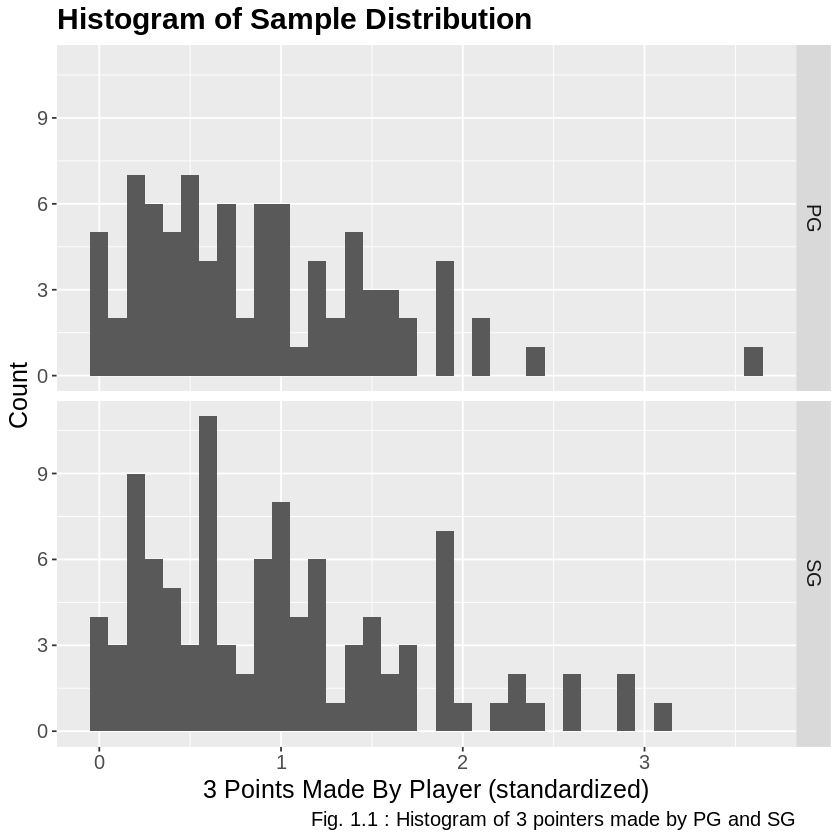

In [42]:
# Plotting the sample distribution using a histogram
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_dist <- tidy_nba |> 
    ggplot(aes(x = three_pts_standardized)) + 
    geom_histogram(binwidth = .1) + 
    xlab("3 Points Made By Player (standardized)") +
    ylab("Count") +
    labs(caption = "Fig. 1.1 : Histogram of 3 pointers made by PG and SG") +
    facet_grid(rows = vars(pos)) + 
    ggtitle("Histogram of Sample Distribution") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_dist

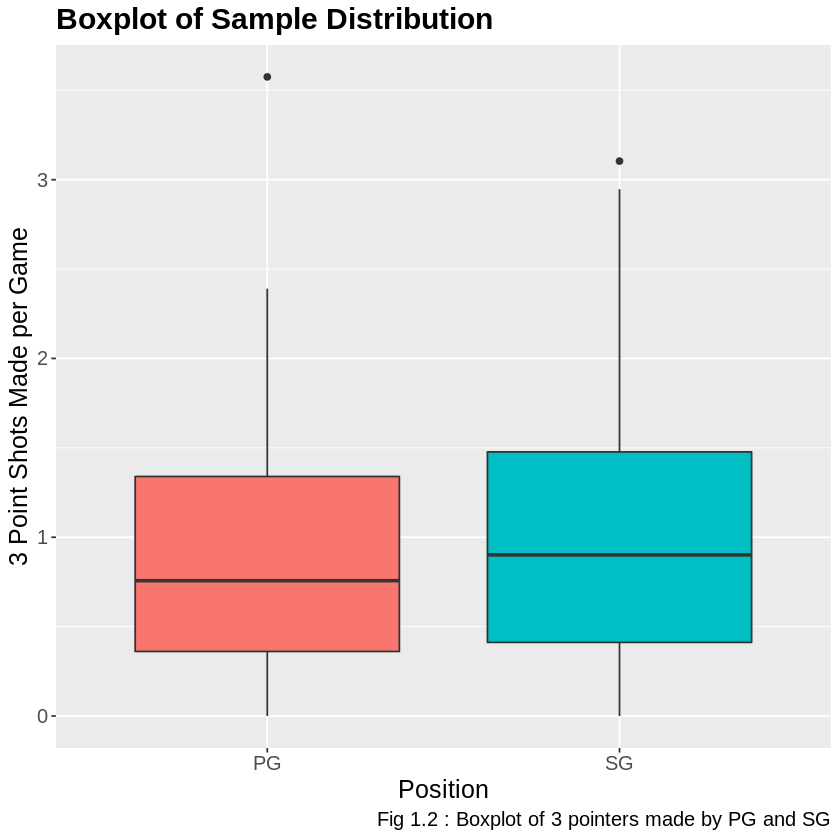

In [43]:
# Plotting the sample distribution using a histogram
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_boxplot <- tidy_nba |> 
    ggplot(aes(x = pos, y = three_pts_standardized, fill = pos)) +
    geom_boxplot() + 
    ggtitle("Boxplot of Sample Distribution") +
    xlab("Position") +
    ylab("3 Point Shots Made per Game") +
    labs(caption = "Fig 1.2 : Boxplot of 3 pointers made by PG and SG") +
    guides(fill = "none") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_boxplot

In Figure 1.1 and 1.2, we notice that both distributions are slightly right skewed and we see that there is an outlier in the `PG` and `SG` data. Since the distribution is not normal enough, median is an appropriate choice in summary statistic. Since CLT does not apply to medians, we will use the bootstrap approach to conduct our hypothesis test and construct our confidence interval.

## Hypothesis Test
Due to sampling variability, simply concluding that Shooting Guards make more 3 pointers than Point Guards from this sample is not appropriate and very unconvincing. Thus, we will perform a hypothesis test at the 5% significance level. 
Since we are working with quantitative variables between two independent groups, we will use a difference in medians ($\eta_1 - \eta_2$) as our population parameter where $\eta_1$ is median `three_pts_standardized` of point guards and $\eta_2$ is median `three_pts_standardized` of shooting guards.

In [44]:
# Median standardized three-pointers of point guards
mu_1 <- nba_summary |>
    filter(pos == "PG") |>
    pull(median_three_pts)

# Median standardized three-pointers of shooting guards
mu_2 <- nba_summary |>
    filter(pos == "SG") |>
    pull(median_three_pts)

### Hypotheses
- **Null Hypothesis:** There is no difference in the median `three_pts_standardized` between point guards and shooting guards.<br>
    $H_0:\eta_1 - \eta_2 = 0$
- **Alternative Hypothesis:** The median `three_pts_standardized` of shooting guards is greater than that of point guards. <br>
    $H_A:\eta_1 - \eta_2 < 0$

### Conducting Hypothesis Test

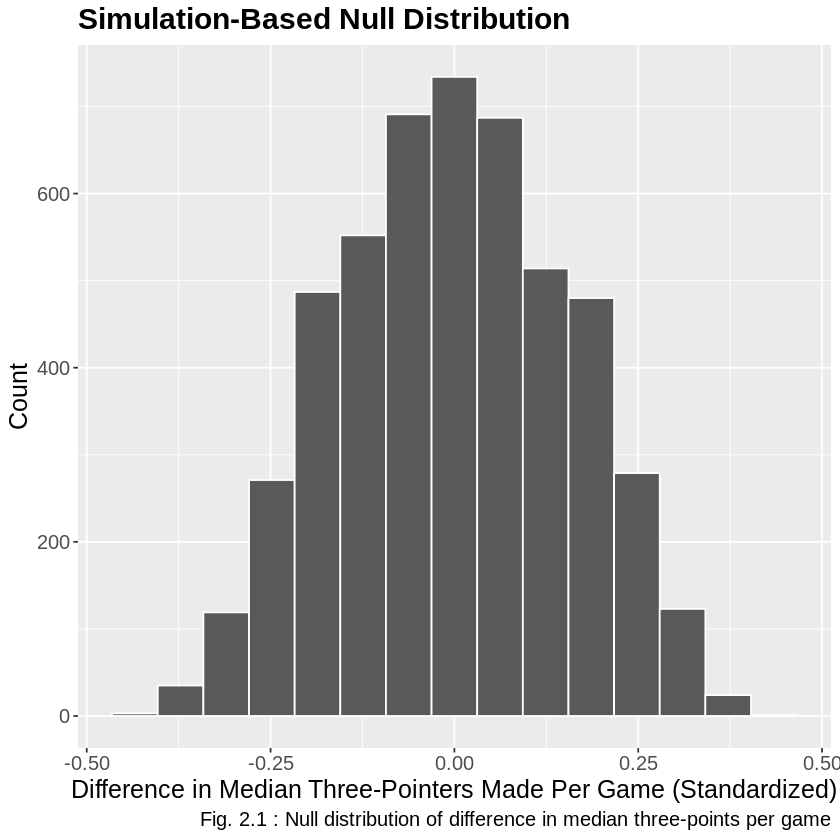

In [45]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Generating the null distribution
null_dist <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    hypothesize(null = "independence") |>
    generate(reps = 5000, type = "permute") |>
    calculate(stat = "diff in medians", c("PG", "SG"))

# Plotting the null model
null_model <- visualize(null_dist) +
    ylab("Count") +
    xlab("Difference in Median Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 2.1 : Null distribution of difference in median three-points per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

null_model

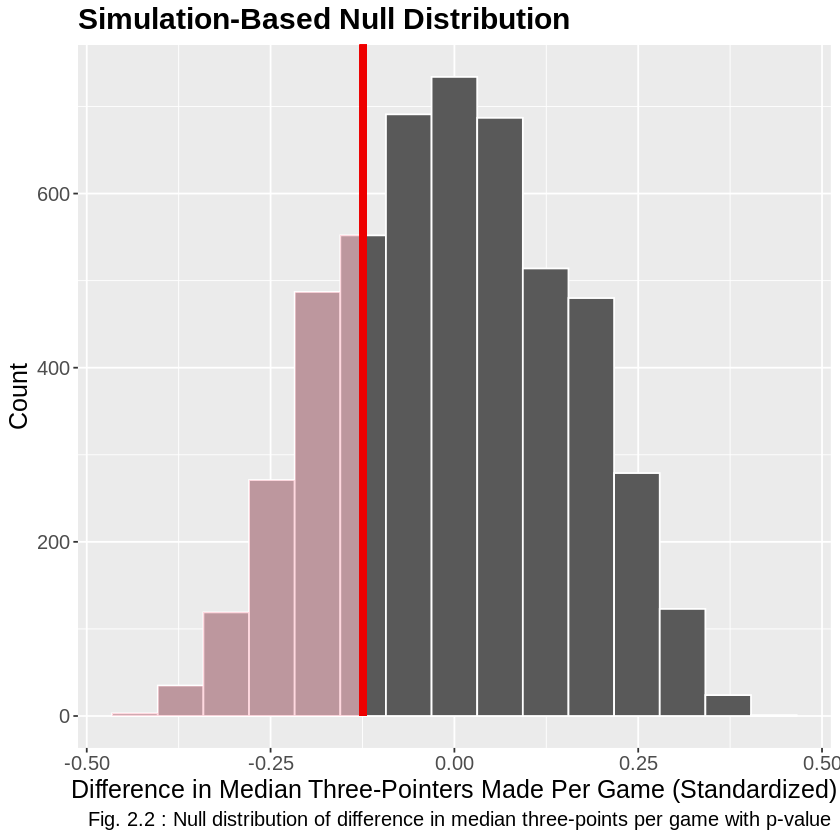

In [46]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Observed difference in mean of standardized three-pointers
obs_diff_median <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    calculate(stat = "diff in medians", c("PG", "SG"))

# Calculating the p-value
p_value <- null_dist |>
  get_p_value(obs_stat = obs_diff_median, direction = "left")

# Visualizing the p-value
p_value_model <- null_model +
    shade_p_value(obs_stat = obs_diff_mean, direction = "left") +
    labs(caption = "Fig. 2.2 : Null distribution of difference in median three-points per game with p-value") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

p_value_model

In [48]:
# Table for p-value and significance level
alpha <- c(0.05)

tibble(p_value, alpha)

p_value,alpha
<dbl>,<dbl>
0.2088,0.05


Since the p-value (0.2088) is greater than the significance level (0.05), we fail to reject the null hypothesis. Thus, there is insufficient evidence to conclude that shooting guards score more three-pointers than point guards.

## Confidence Interval

We will construct a 1 - $\alpha$ = 95% confidence interval using a bootstrap approach and determine where the observed difference in medians falls within that interval. This is another method of performing the same hypothesis test above at the 5% significance level.

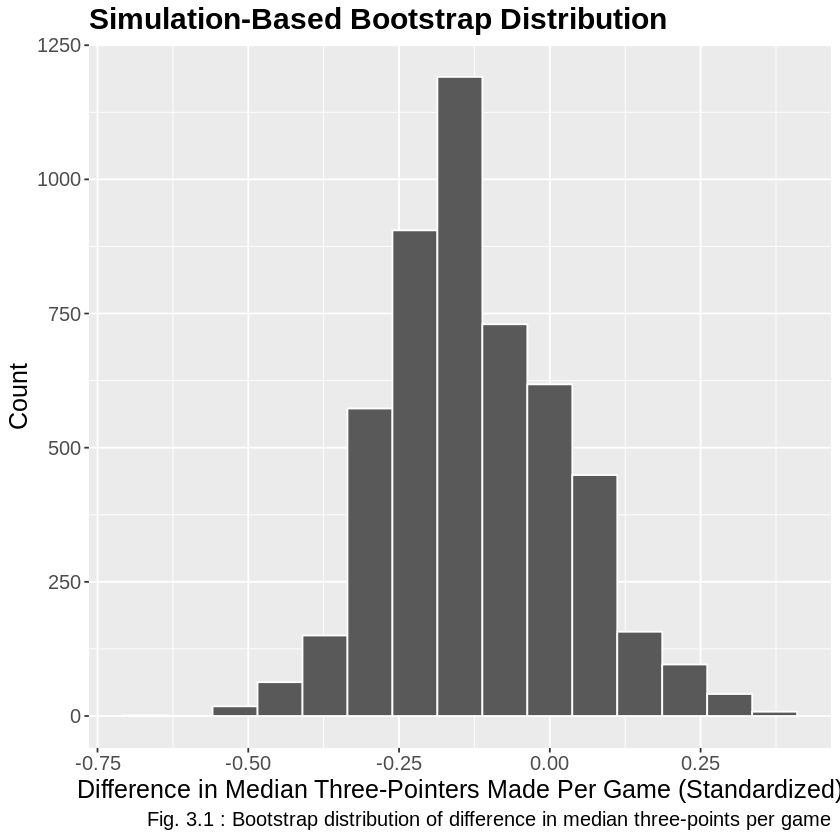

In [60]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Generating the bootstrap distribution
diff_in_medians_bootstrap <- tidy_nba |> 
    specify(formula = three_pts_standardized ~ pos) |> 
    generate(reps = 5000, type = "bootstrap") |> 
    calculate(stat = "diff in medians", order = c("PG", "SG"))

# Plotting bootstrap distribution
bootstrap_dist <- visualize(diff_in_medians_bootstrap) +
    ylab("Count") +
    xlab("Difference in Median Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 3.1 : Bootstrap distribution of difference in median three-points per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

bootstrap_dist

### Constructing the 95% Percentile Confidence Interval

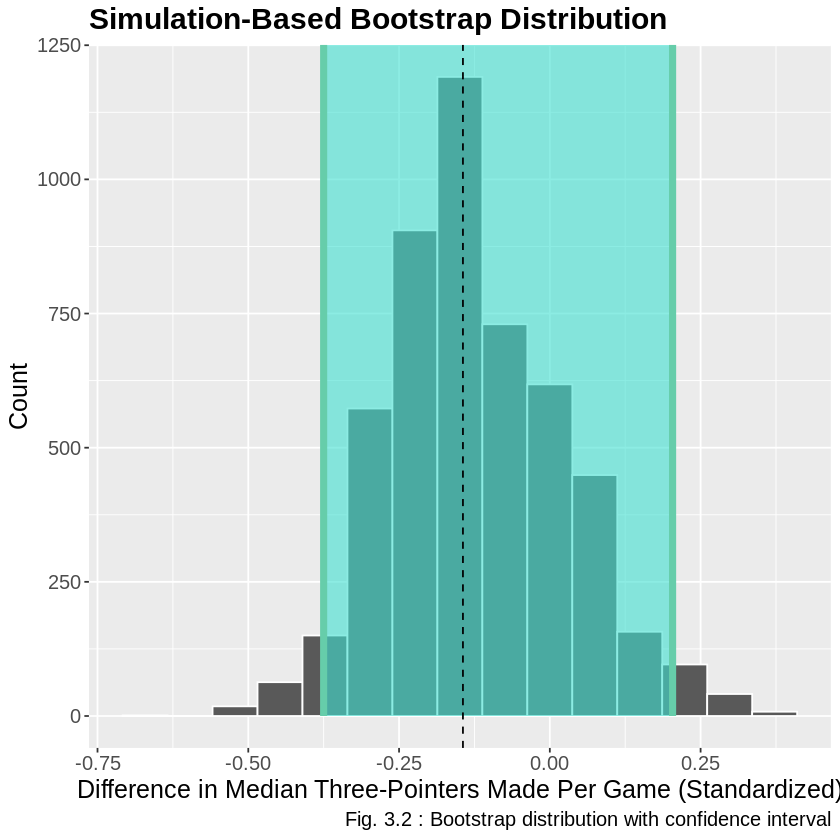

In [62]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Getting the 95% percentile confidence interval
diff_in_medians_ci <- diff_in_medians_bootstrap |> 
    get_ci(level = 0.95, type = "percentile")

# Visualizing the confidence interval and observed test statistic
diff_in_medians_ci_plot <- diff_in_medians_bootstrap |> 
    visualize() +
    shade_ci(endpoints = diff_in_medians_ci) + 
    geom_vline(xintercept = as.numeric(obs_diff_median), linetype = "dashed") +
    ylab("Count") +
    xlab("Difference in Median Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 3.2 : Bootstrap distribution with confidence interval") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

diff_in_medians_ci_plot

As seen in Figure 3.2, the observered test statistic falls within the 95% (1 - $\alpha$) confidence interval which means that we fail to reject the null hypothesis. This conclusion coincides with the result we obtained during our hypotheiss test above.

### Discussion 

As shown above, both our p-value of 20.88% and a difference of 0 falling within our 95% confidence interval for the difference in medians both suggest that there is no significant difference in the number of 3-point shots made by point gaurds and shooting gaurds in the 2017-28 NBA season, which suggests that both groups are rougly equally proficent in shooting 3s. This result is what we expected to find, with the rise in 3 point shots made by point gaurds, we predicted it would be tough for shooting gaurds to outclass them in todays game.  The results of this study could result in choaches reevaluating the types of players they place in each position. With two high scoring positions, it could now be an option for coaches to sacrifice the defensive capabilites for shooting capabilites in some players to help them win more games. A sbsequent study could test weather teams with a higher scorring point gaurd, win more games than tems with a higher scorring shooting gaurd.

### References

1. Analysis of the final actions used in basketball during formative years ... (n.d.). Retrieved March 16, 2023, from https://www.researchgate.net/publication/255994752_Analysis_of_the_final_actions_used_in_basketball_during_formative_years_according_to_player's_position 

2. Camli, M. B. (2018, November 4). NBA Player stats 2017-2018. Kaggle. Retrieved March 16, 2023, from https://www.kaggle.com/datasets/mcamli/nba17-18 

3. Examining positional difference in basketball players’ field goal ... (n.d.). Retrieved March 16, 2023, from https://journals.sagepub.com/doi/abs/10.1177/17479541221096772 